In [2]:
import re
from datetime import datetime
from io import StringIO

import numpy as np
import pandas as pd
#@formatter:off
%matplotlib inline
#@formatter:on
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
import re

seaborn.set()

### 1 US state data

In [3]:
pop = pd.read_csv('data/state-population.csv')
areas = pd.read_csv('data/state-areas.csv')
abbrevs = pd.read_csv('data/state-abbrevs.csv')
print(pop.head())
print(areas.head())
print(abbrevs.head())

merged = pd.merge(pop, abbrevs, left_on='state/region', right_on='abbreviation', how='outer')
print(merged['abbreviation'].unique().size, end=' vs ')
print(merged['state/region'].unique().size)
merged.drop('abbreviation', axis=1, inplace=True)
print(merged.head())

print(merged.isnull().any())
print(merged[merged['state'].isnull()].head())
print(merged[merged['state'].isnull()]['state/region'].unique())

merged.loc[merged['state/region'] == 'PR', 'state'] = 'Puerto Rico'
merged.loc[merged['state/region'] == 'USA', 'state'] = 'United States'
print(merged.isnull().any())

final = pd.merge(merged, areas, how='left')
print(final.isnull().any())

print(final.loc[final['area (sq. mi)'].isnull(), 'state/region'].unique())
final.dropna(inplace=True)

data2010 = final.query("ages == 'total' & year == 2010")
print(data2010.head())
data2010.set_index(['state'], inplace=True)
data2010['density'] = data2010['population'] / data2010['area (sq. mi)']
data2010.sort_values(by='density', ascending=False, inplace=True)

print(data2010.head())
print(data2010.tail())

  state/region     ages  year  population
0           AL  under18  2012   1117489.0
1           AL    total  2012   4817528.0
2           AL  under18  2010   1130966.0
3           AL    total  2010   4785570.0
4           AL  under18  2011   1125763.0
        state  area (sq. mi)
0     Alabama          52423
1      Alaska         656425
2     Arizona         114006
3    Arkansas          53182
4  California         163707
        state abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA
52 vs 53
  state/region     ages  year  population    state
0           AL  under18  2012   1117489.0  Alabama
1           AL    total  2012   4817528.0  Alabama
2           AL  under18  2010   1130966.0  Alabama
3           AL    total  2010   4785570.0  Alabama
4           AL  under18  2011   1125763.0  Alabama
state/region    False
ages            False
year            False
population       True
state    

<ipython-input-3-7a5273cea3b8>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2010['density'] = data2010['population'] / data2010['area (sq. mi)']
<ipython-input-3-7a5273cea3b8>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2010.sort_values(by='density', ascending=False, inplace=True)


### 2 Births data

   year  month  day gender  births
0  1969      1  1.0      F    4046
1  1969      1  1.0      M    4440
2  1969      1  2.0      F    4454
3  1969      1  2.0      M    4548
4  1969      1  3.0      F    4548
gender         F         M
decade                    
1960     1753634   1846572
1970    16263075  17121550
1980    18310351  19243452
1990    19479454  20420553
2000    18229309  19106428
       births
1 1  4009.225
  2  4247.400
  3  4500.900
  4  4571.350
  5  4603.625
              births
2012-01-01  4009.225
2012-01-02  4247.400
2012-01-03  4500.900
2012-01-04  4571.350
2012-01-05  4603.625


<ipython-input-4-5df2a7407861>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(['', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])


<AxesSubplot:>

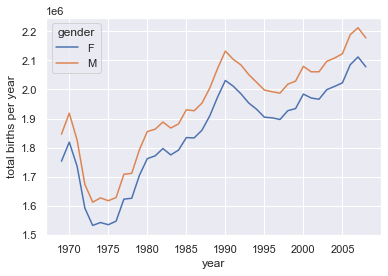

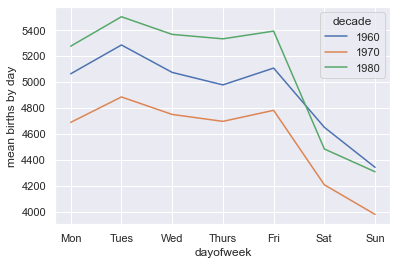

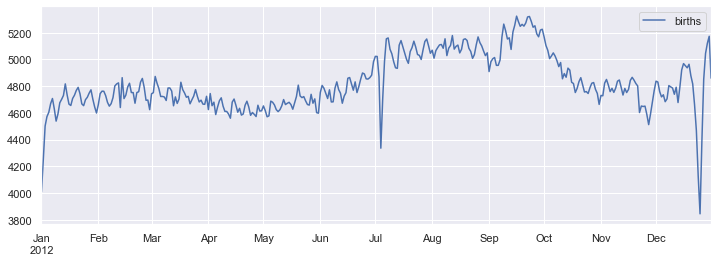

In [4]:
births = pd.read_csv('data/births.csv')
print(births.head())

births['decade'] = 10 * (births['year'] // 10)
print(births.pivot_table('births', index='decade', columns='gender', aggfunc='sum'))

births.pivot_table('births', index='year', columns='gender', aggfunc='sum').plot()
plt.ylabel('total births per year')

quartiles = np.percentile(births['births'], [25, 50, 75])
mu = quartiles[1]
sig = 0.74 * (quartiles[2] - quartiles[0])

births = births.query("(births > @mu - 5 * @sig) & (births < @mu + 5 * @sig)")
births['day'] = births['day'].astype(int)
births.index = pd.to_datetime(10000 * births.year + 100 * births.month + births.day, format='%Y%m%d')
births['dayofweek'] = births.index.dayofweek

births.pivot_table('births', index='dayofweek', columns='decade', aggfunc='mean').plot()
plt.gca().set_xticklabels(['', 'Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'])
plt.ylabel('mean births by day')

births_by_date = births.pivot_table('births', [births.index.month, births.index.day])
print(births_by_date.head())
births_by_date.index = [pd.Timestamp(2012, month, day) for (month, day) in births_by_date.index]
print(births_by_date.head())

fig, ax = plt.subplots(figsize=(12, 4))
births_by_date.plot(ax=ax)

### 3.1 Recipes database

In [5]:
# Читаем весь файл в массив Python (d)
with open('data/recipeitems-latest.json', 'r', encoding='utf-8') as f:
    # Извлекаем каждую строку (d)
    data = (line.strip() for line in f)
    # Преобразуем так, чтобы каждая строка была элементом списка (d)
    data_json = "[{0}]".format(','.join(data))
# Читаем результат в виде JSON (d)
recipes = pd.read_json(StringIO(data_json))

print(recipes.shape)
print(recipes.iloc[0])

FileNotFoundError: [Errno 2] No such file or directory: 'data/recipeitems-latest.json'

### 3.2

In [6]:
print(recipes['ingredients'].str.len().describe())
print(recipes['name'][np.argmax(recipes['ingredients'].str.len())])
print(recipes['description'].str.contains('[Bb]reakfast').sum())
print(recipes['ingredients'].str.contains('[Cc]innamon').sum())
print(recipes['ingredients'].str.contains('[Cc]inamon').sum())

NameError: name 'recipes' is not defined

### 3.3

In [7]:
# СОСТАВЛЯЕМ РЕКОМЕНДАТЕЛЬНУЮ СИСТЕМУ (d)
spice_list = ['salt', 'pepper', 'oregano', 'sage', 'parsley', 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']

spice_df = pd.DataFrame(
    dict((spice, recipes['ingredients'].str.contains(spice, re.IGNORECASE)) for spice in spice_list))
print(spice_df)

selection = spice_df.query('parsley & paprika & tarragon')
print(recipes.loc[selection.index, 'name'])

NameError: name 'recipes' is not defined

### 4.1 The number of bicycles in Seattle

In [8]:
data = pd.read_csv('data/Fremont_Bridge_Bicycle_Counter.csv', index_col='Date', parse_dates=True)
print(data.head())

                     Fremont Bridge Total  Fremont Bridge East Sidewalk  \
Date                                                                      
2019-11-01 00:00:00                  12.0                           7.0   
2019-11-01 01:00:00                   7.0                           0.0   
2019-11-01 02:00:00                   1.0                           0.0   
2019-11-01 03:00:00                   6.0                           6.0   
2019-11-01 04:00:00                   6.0                           5.0   

                     Fremont Bridge West Sidewalk  
Date                                               
2019-11-01 00:00:00                           5.0  
2019-11-01 01:00:00                           7.0  
2019-11-01 02:00:00                           1.0  
2019-11-01 03:00:00                           0.0  
2019-11-01 04:00:00                           1.0  


### 4.2

                     Total  East  West
Date                                  
2019-11-01 00:00:00   12.0   7.0   5.0
2019-11-01 01:00:00    7.0   0.0   7.0
2019-11-01 02:00:00    1.0   0.0   1.0
2019-11-01 03:00:00    6.0   6.0   0.0
2019-11-01 04:00:00    6.0   5.0   1.0
               Total           East           West
count  142864.000000  142864.000000  142864.000000
mean      111.083716      50.539667      60.544049
std       141.607196      65.258093      88.019141
min         0.000000       0.000000       0.000000
25%        14.000000       6.000000       7.000000
50%        60.000000      28.000000      30.000000
75%       145.000000      68.000000      74.000000
max      1097.000000     698.000000     850.000000


<AxesSubplot:xlabel='Date'>

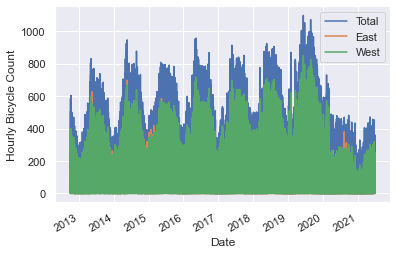

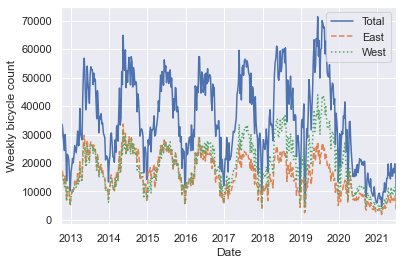

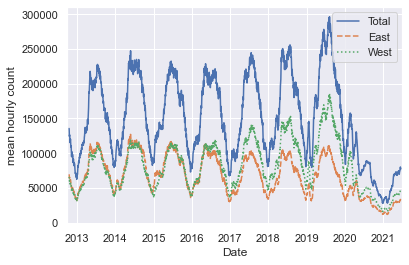

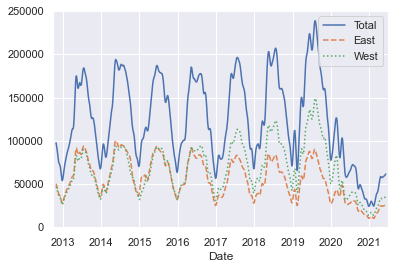

In [9]:
data.columns = ['Total', 'East', 'West']
print(data.head())
print(data.dropna().describe())

data.plot()
plt.ylabel('Hourly Bicycle Count')

weekly = data.resample('W').sum()
weekly.plot(style=['-', '--', ':'])
plt.ylabel('Weekly bicycle count')

daily = data.resample('D').sum()
daily.rolling(window=30, center=True).sum().plot(style=['-', '--', ':'])
plt.ylabel('mean hourly count')

daily.rolling(window=50, win_type='gaussian', center=True).sum(std=10).plot(style=['-', '--', ':'])

### 4.3

<AxesSubplot:title={'center':'Weekends'}, xlabel='time'>

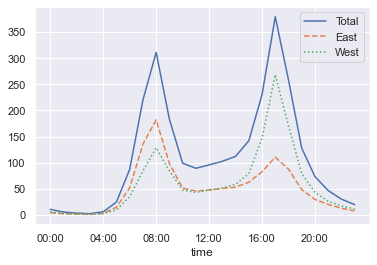

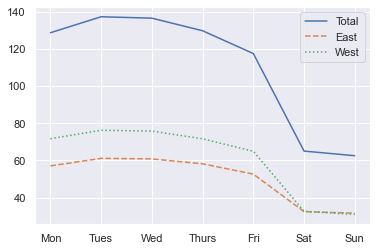

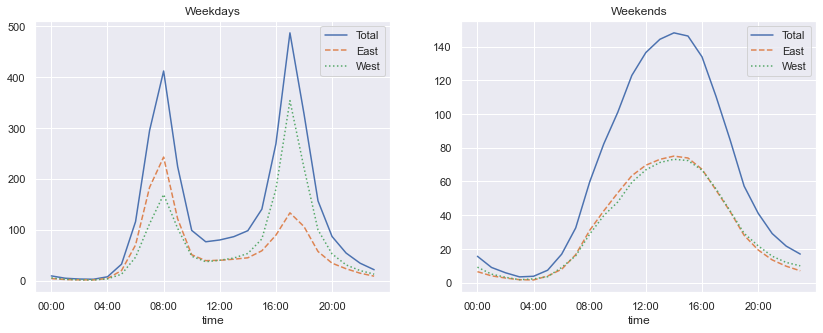

In [10]:
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time = data.groupby(data.index.time).mean()
by_time.plot(xticks=hourly_ticks, style=['-', '--', ':'])

by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=['-', '--', ':'])

by_time = data.groupby([data.index.dayofweek < 5, data.index.time]).mean()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc[True].plot(ax=ax[0], title='Weekdays', xticks=hourly_ticks, style=['-', '--', ':'])
by_time.loc[False].plot(ax=ax[1], title='Weekends', xticks=hourly_ticks, style=['-', '--', ':'])
